# Entrainement de réseaux de neurones `pytorch`

**Objectif**

Entrainer un modèle de regréssion à predire les prix d'un type de bien choisi (appartements ou maison) pour une zone géographique donnée (Paris, Marseille, etc.).

**Données**

`DVF+` est une base de données construite à partir des bases de données `DVF` (Demandes de Valeurs Foncières) & `BNB` (Base Nationale des Bâtiments). Cette base a été construite en utilisant les méthodes du module `preprocessing` de la librairie `lib`. 

**Méthode** 

1. Choix d'une zone géographique (`geo_area`) et d'une type de bien (`property_type`)

<br>

2. Préparation du jeu de donneés pour la modélisation 
    - Filtrage des données (nombre de pièces, surface habitable, surface terrain, prix/m²)
    - Application du logarithme à la variable `l_valeur_fonciere`
    - Ajout des variables de tendance des prix du marché: moyenne mobile avec lag de 1 jour appliquée à la variable `valeur_fonciere`
    - Création des dummies 
    - Suppression des variables ayant une proportion de donnnées manquantes trop élevée

<br>

3. Séparation des jeux de données d'entrainement & test
    - Ordonner les transactions par ordre chronologique
    - Les 80% premières transactions sont dans le jeu de données train
    - Les 20% suivantes sont dans le jeu de données test 

<br>

4. Sélection des variables 
    - Calcul de l'information mutuelle (MI) entre les variables explicatives et la cible (`valeur_fonciere` ou `l_valeur_fonciere`)
    - `RandomForestRegressor` pour récupérer l'importance des variables mesurée par la *Mean Decrease Gini* (MDG)
    - Sélection des variables dont l'importance (MI et/ou MDG) est supérieure à seuil prédéfini (ex: quantile d'ordre 75%) 

<br>

5. Entrainement et validation du réseau de neurones
    - Architecture de type MLP

## Setup

In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [238]:
from lib.enums import IDF

from lib.dataset import (
    load_dvfplus, 
    prepare_dataset, 
    prepare_dummies, 
    temporal_train_test_split, 
    get_feature_vector, 
    get_target_vector, 
    compute_mutual_info, 
    compute_rf_importances, 
    select_important_features,
    to_dataloader, 
)

from lib.preprocessing.utils import get_na_proportion

from lib.dataset.utils import (
    get_categorical_vars, 
    get_most_frequent_levels,
    transform_price, 
    scale_features
)

from lib.model import (
    MLP, 
    predict_mlp, 
    plot_predictions, 
) 

from lib.model.optimize import optimize_mlp

from lib.model.loader import save_model, load_model

In [4]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import rich 
from tqdm import tqdm

from multiprocessing import cpu_count

import pickle as pkl

In [139]:
from sklearn.preprocessing import MinMaxScaler

import torch 
import torch.nn as nn
import torch.optim as optim

In [6]:
# garbage collector
import gc
gc.collect()

0

In [7]:
pd.set_option("display.max_columns", None)

In [8]:
DATA_DIR = "../data/"
BACKUP_DIR = "../backup/"

CPU_COUNT = cpu_count()

## Data

### Import

In [9]:
df_args = {"geo_area": "Paris", "property_type": "flats"}

df = load_dvfplus(zip_dir=DATA_DIR, zip_name="dvf+", **df_args)

C:\Users\pemma\AppData\Local\Temp/ipykernel_1196/175102799.py:3: DtypeWarning: Columns (8,18,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_dvfplus(zip_dir=DATA_DIR, zip_name="dvf+", **df_args)


In [10]:
region = None
departement = "Val-de-Marne"

if df_args["geo_area"] == "urban_areas":
    if region is not None:
        df = df.loc[df.nom_region==region, :]
    elif departement is not None:
        df = df.loc[df.nom_departement==departement, :]

In [13]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,dependance,code_region,nom_departement,nom_region,degre_densite,pop,annee,trimestre,mois,jour,parcelle_id,code_iris,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_std,estim_ges_std,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,ratio_ges_conso,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),baie_u,mur_u_ext,pb_u,ph_u,mur_pos_isol_ext,prc_s_vitree_ext,presence_balcon,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,alea_argiles,alea_radon
0,2017-731653,2017-07-04,1,Vente,571110.0,16.0,NaN,RUE SAINT GILLES,8627,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AM0035,NaN,NaN,12.0,NaN,36.0,49.51,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,42.0,3.0,NaN,NaN,NaN,NaN,NaN,2.366404,48.858043,0,11,Paris,Île-de-France,Paris,34788.0,2017,3,7,4,75103000AM0035,751031102.0,<1948,AVANT_1949,16.0,35.0,269.0,13.0,208.5,4.4,69.0,8.0,485.0,16.0,0.23,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,323.0,0.0,0.0,26.0,23.0,26.0,NaN,Faible
1,2017-731655,2017-07-04,1,Vente,1578150.0,66.0,NaN,RUE DE LISBONNE,5708,75008.0,75108,Paris 8e Arrondissement,75,NaN,NaN,75108000CO0044,NaN,NaN,61.0,139.02,62.0,NaN,66.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,135.0,4.0,NaN,NaN,NaN,NaN,NaN,2.306998,48.877579,0,11,Paris,Île-de-France,Paris,36453.0,2017,3,7,4,75108000CO0044,751083203.0,<1948,AVANT_1949,20.0,47.0,197.0,40.3,21.3,3.2,181.9,38.0,212.0,42.6,0.18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,NaN,Faible
2,2017-731657,2017-07-05,1,Vente,2810880.0,27.0,NaN,RUE MARBEUF,5993,75008.0,75108,Paris 8e Arrondissement,75,NaN,NaN,75108000AR0060,NaN,NaN,93.0,219.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,220.0,6.0,NaN,NaN,NaN,NaN,NaN,2.304234,48.869357,1,11,Paris,Île-de-France,Paris,36453.0,2017,3,7,5,75108000AR0060,751082903.0,<1948,AVANT_1949,24.0,37.0,1604.3,51.6,1283.7,41.8,183.0,5.0,2721.0,88.0,0.03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,271.0,0.0,0.0,164.0,59.0,104.0,NaN,Faible
3,2017-731658,2017-07-03,1,Vente,130000.0,9.0,NaN,RUE DES INNOCENTS,4718,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AO0081,NaN,NaN,114.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,14.0,1.0,NaN,NaN,NaN,NaN,NaN,2.347393,48.860387,0,11,Paris,Île-de-France,Paris,16252.0,2017,3,7,3,75101000AO0081,751010201.0,<1948,AVANT_1949,19.0,36.0,231.8,7.3,136.2,4.2,53.5,1.7,395.0,12.0,0.03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,ITI,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,147.0,97.0,105.0,NaN,Faible
4,2017-731661,2017-07-05,1,Vente,485000.0,30.0,NaN,RUE BEAUBOURG,759,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AT0078,NaN,NaN,4.0,50.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,38.0,3.0,NaN,NaN,NaN,NaN,NaN,2.354479,48.861846,0,11,Paris,Île-de-France,Paris,34788.0,2017,3,7,5,75103000AT0078,751031202.0,<1948,AVANT_1949,18.0,36.0,291.4,37.7,135.4,20.9,200.0,14.0,447.0,53.2,0.23,0.0,0.0,0.0,NaN,NaN,NaN,NaN,

In [14]:
df.shape

(160757, 91)

### Exploration 

L'objectif est de représenter les variables `valeur_fonciere`, `nombre_pieces_principales`, `surface_reelle_bati` et `surface_terrain` pour déterminer ensuite des filtres à appliquer aux données. 

In [15]:
tmp = df.copy()

tmp["valeur_fonciere_m2"] = tmp.apply(
    lambda row: transform_price(row.valeur_fonciere, log=False, area=row.surface_reelle_bati), 
    axis=1
)

Quelques statistiques descriptives relatives aux variables quantitatives qui décrivent les biens. Ces résultats sont utiles pour identifier les valeurs aberrantes et déterminer des seuils. 

In [16]:
vars = ["valeur_fonciere_m2", "surface_reelle_bati", "surface_terrain"]
summary = tmp[vars].describe(percentiles=[.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
summary 

,valeur_fonciere_m2,surface_reelle_bati,surface_terrain
count,1.606810e+05,160756.000000,138.000000
mean,1.063960e+04,53.627877,420.840580
std,1.608160e+04,39.868650,576.248847
min,3.623188e-03,1.000000,33.000000
1%,6.122449e+01,9.000000,36.370000
5%,4.526316e+03,15.000000,51.000000
10%,6.666667e+03,18.000000,70.000000
25%,8.548387e+03,28.000000,144.250000
50%,1.019048e+04,43.000000,210.500000
75%,1.193878e+04,68.000000,453.250000


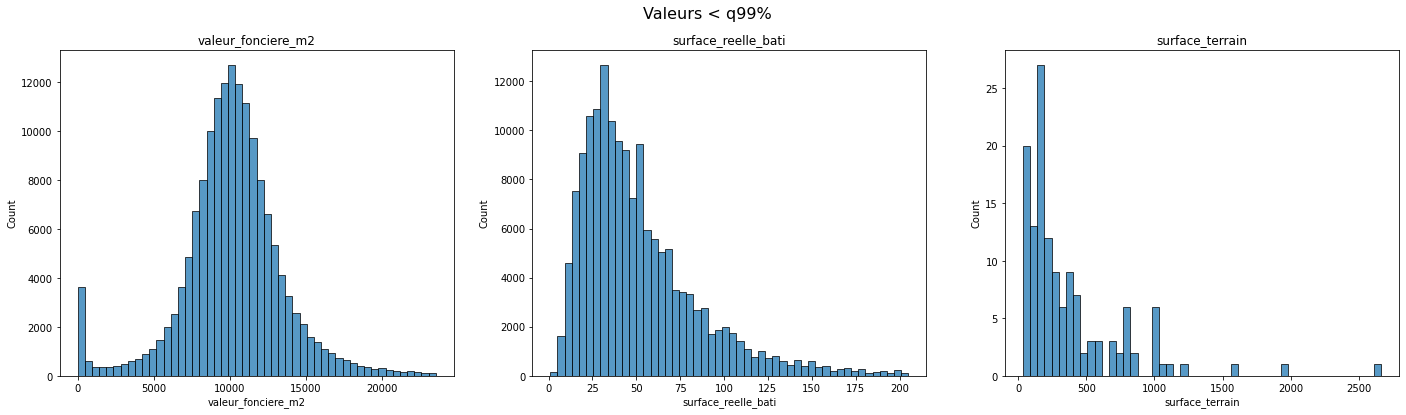

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
fig.suptitle("Valeurs < q99%", fontsize=16)

for var, ax in zip(vars, axes.flatten()): 
    thresold = summary[var]["99%"]

    x = tmp.loc[tmp[var] < thresold, var].dropna()
    sns.histplot(x, ax=ax, bins=50)
    ax.set_title(var);

In [18]:
for var in vars: 
    na_prop = get_na_proportion(tmp, var)
    print(f"{var}: {round(100 * na_prop, 3)}% valeurs manquantes")

valeur_fonciere_m2: 0.047% valeurs manquantes
surface_reelle_bati: 0.001% valeurs manquantes
surface_terrain: 99.914% valeurs manquantes


In [19]:
tmp.nombre_pieces_principales.value_counts(dropna=False, normalize=True)

2.0     0.341186
1.0     0.261643
3.0     0.224625
4.0     0.102229
5.0     0.044334
6.0     0.015869
7.0     0.006028
8.0     0.001860
0.0     0.001219
9.0     0.000467
10.0    0.000292
11.0    0.000106
12.0    0.000037
13.0    0.000019
16.0    0.000012
20.0    0.000012
17.0    0.000012
22.0    0.000006
21.0    0.000006
19.0    0.000006
23.0    0.000006
26.0    0.000006
NaN     0.000006
14.0    0.000006
15.0    0.000006
Name: nombre_pieces_principales, dtype: float64

In [20]:
del tmp 

### Préparation du dataset

Application des filtres statiques sur les variables qui décrivent le bien via le dictionnaire `numeric_filters` : 
- nombre de pièces principales
- surface du bien
- valeur foncière/m² (cf: [meilleursagents](https://www.meilleursagents.com/prix-immobilier/)) 
- surface du terrain (pour les maisons)

Le paramètre `na_thresold` indique la proportion maximale de données manquantes que l'on autorise pour appliquer les techniques d'imputation (par la médiane pour les valeurs numériques, par le mode pour les catégorielles). Les colonnes ayant une proportion de donnnées manquantes supérieures à `na_thresold` sont supprimées. 

Les paramètres de `mov_av_windows` sont utilisées pour calculer les moyennes mobiles du prix moyen journalier ($\approx$ prix du marché à court/moyen/long terme). Notons que l'on applique un lag de 1 jour puisqu'il est nécessaire d'utiliser le prix du marché à la date $t-1$ pour expliquer le prix du bien vendu à la date $t$. Lorsque le paramètre `neighborhood_var` est renseignée, on calcule le prix du marché à court/moyen/long terme par quartier dans la base étudiée. Un quartier peut être un arrondissement, une commune ou un département. 

In [21]:
preproc_args = {

    "numeric_filters": {
        "nombre_pieces_principales": (1, 6), 
        "surface_reelle_bati": (9, 150), 
        "valeur_fonciere_m2": (2000, 20000)
    },  

    "na_threshold": 0.5,

    "mov_av_windows": [7, 14, 30, 90], 

    "neighborhood_var": "arrondissement"
    
}

df_prepoc, dvf_vars, bnb_vars = prepare_dataset(df, target_var="l_valeur_fonciere", **preproc_args)

c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Preprocessing summary:

{
    'created': [
        'l_valeur_fonciere',
        'l_surface_reelle_bati',
        'l_hauteur_mean',
        'l_altitude_sol_mean',
        'l_conso_ener_mean',
        'l_estim_ges_mean',
        'l_conso_ener_std',
        'l_estim_ges_std',
        'l_conso_ener_min',
        'l_estim_ges_min',
        'l_conso_ener_max',
        'l_estim_ges_max',
        'l_ratio_ges_conso',
        'l_distance_batiment_historique_plus_proche',
        'valeur_fonciere_m2',
        'arrondissement',
        'l_valeur_fonciere_ma7',
        'l_valeur_fonciere_ma14',
        'l_valeur_fonciere_ma30',
        'l_valeur_fonciere_ma90'
    ],
    'removed': [
        'surface_terrain',
        'baie_u',
        'mur_u_ext',
        'pb_u',
        'ph_u',
        'prc_s_vitree_ext',
        'presence_balcon',
        'alea_argiles',
        'nom_commune'
    ]
}

In [22]:
df_prepoc.head()

,id_mutation,date_mutation,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,dependance,nom_departement,trimestre,mois,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_std,estim_ges_std,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,ratio_ges_conso,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),mur_pos_isol_ext,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,alea_radon,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_std,l_estim_ges_std,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_ratio_ges_conso,l_distance_batiment_historique_plus_proche,valeur_fonciere_m2,arrondissement,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90
0,2017-731653,2017-07-04,571110.0,42.0,3,0,Paris,3,7,<1948,AVANT_1949,16.0,35.0,269.0,13.0,208.5,4.4,69.0,8.0,485.0,16.0,0.23,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,323.0,0.0,0.0,26.0,23.0,26.0,Faible,13.255337,3.737670,2.772589,3.555348,5.594711,2.564949,5.339939,1.481605,4.234107,2.079442,6.184149,2.772589,-1.469676,5.777652,13597.857143,3,NaN,NaN,NaN,NaN
1,2017-731655,2017-07-04,1578150.0,135.0,4,0,Paris,3,7,<1948,AVANT_1949,20.0,47.0,197.0,40.3,21.3,3.2,181.9,38.0,212.0,42.6,0.18,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,Faible,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,3.058707,1.163151,5.203457,3.637586,5.356586,3.751854,-1.714798,5.961005,11690.000000,8,NaN,NaN,NaN,NaN
2,2017-731658,2017-07-03,130000.0,14.0,1,0,Paris,3,7,<1948,AVANT_1949,19.0,36.0,231.8,7.3,136.2,4.2,53.5,1.7,395.0,12.0,0.03,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,147.0,97.0,105.0,Faible,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,4.914124,1.435085,3.979682,0.530628,5.978886,2.484907,-3.506558,6.093570,9285.714286,1,NaN,NaN,NaN,NaN
3,2017-731661,2017-07-05,485000.0,38.0,3,0,Paris,3,7,<1948,AVANT_1949,18.0,36.0,291.4,37.7,135.4,20.9,200.0,14.0,447.0,53.2,0.23,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,6.0,60.0,40.0,45.0,Faible,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,4.908233,3.039749,5.298317,2.639057,6.102559,3.974058,-1.469676,4.615121,12763.157895,3,NaN,NaN,NaN,NaN
4,2017-731664,2017-07-11,820000.0,83.0,4,0,Paris,3,7,1970-1988,AVANT_1949,27.0,47.0,459.7,27.3,113.2,7.9,379.6,21.7,539.7,32.9,0.06,0.0,0.0,0.0,non isole,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,164.0,0.0,0.0,32.0,5.0,6.0,Faible,13.617060,4.418841,3.295837,3.850148,6.130574,3.306887,4.729156,2.066863,5.939118,3.077312,6.291013,3.493473,-2.813411,5.099866,9879.518072,8,13.6541,NaN,NaN,NaN


In [23]:
df_prepoc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147790 entries, 0 to 147789
Data columns (total 61 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   id_mutation                                               147790 non-null  object 
 1   date_mutation                                             147790 non-null  object 
 2   valeur_fonciere                                           147790 non-null  float64
 3   surface_reelle_bati                                       147790 non-null  float64
 4   nombre_pieces_principales                                 147790 non-null  object 
 5   dependance                                                147790 non-null  int64  
 6   nom_departement                                           147790 non-null  object 
 7   trimestre                                                 147790 non-null  object 
 8   mois

### Encodage des dummies

Cette section permet de transformer les variables catégorielles en variables binaires. Pour chaque variable, la catégorie de référence correspond à la plus fréquente dans le jeu de données. Cette catégorie de référence est ensuite supprimée afin d'éviter tout problème de multicolinéarité dans la matrice des variables explicatives. 

In [24]:
# categorical variable = pandas column with <= 30 unique values

categorical_vars = get_categorical_vars(df_prepoc, n_levels_max=30)   
categorical_vars.append("baie_orientation")

categorical_vars

['nombre_pieces_principales',
 'nom_departement',
 'trimestre',
 'mois',
 'periode_construction',
 'periode_construction_max',
 'mur_pos_isol_ext',
 'alea_radon',
 'arrondissement',
 'baie_orientation']

In [25]:
# select most representative levels for each categorical variable
dummy_ref_levels = get_most_frequent_levels(df_prepoc, categorical_vars)
dummy_ref_levels

{'baie_orientation': 'nord',
 'nombre_pieces_principales': '2',
 'nom_departement': 'Paris',
 'trimestre': '3',
 'mois': '7',
 'periode_construction': '<1948',
 'periode_construction_max': 'AVANT_1949',
 'mur_pos_isol_ext': 'ITI',
 'alea_radon': 'Faible',
 'arrondissement': '18'}

In [26]:
df_prepoc, dvf_vars, bnb_vars = prepare_dummies(
    df_prepoc, 
    categorical_vars, 
    dummy_ref_levels, 
    dvf_vars, 
    bnb_vars)

Preprocessing summary:

{
    'created': [
        'mois_8',
        'nombre_pieces_principales_1',
        'arrondissement_1',
        'trimestre_4',
        'arrondissement_2',
        'nombre_pieces_principales_6',
        'mois_2',
        'arrondissement_11',
        'arrondissement_6',
        'mois_6',
        'arrondissement_15',
        'mois_12',
        'arrondissement_12',
        'arrondissement_16',
        'trimestre_3',
        'arrondissement_14',
        'arrondissement_4',
        'arrondissement_7',
        'mois_9',
        'nombre_pieces_principales_2',
        'mois_3',
        'mois_4',
        'arrondissement_17',
        'nombre_pieces_principales_3',
        'arrondissement_9',
        'mois_10',
        'nombre_pieces_principales_4',
        'mois_7',
        'mois_11',
        'arrondissement_10',
        'mois_5',
        'nombre_pieces_principales_5',
        'trimestre_2',
        'arrondissement_8',
        'arrondissement_5',
        'arrondissement_19',
        'trimestre_1',
        'arrondissement_20',
        'arrondissement_18',
        'arrondissement_13',
        'mois_1',
        'arrondissement_3',
        'nom_departement_Paris',
        'periode_construction_max_DE_1961_A_1974',
        'periode_construction_1989-1999',
        'periode_construction_2000-2005',
        'periode_construction_max_APRES_2011',
        'periode_construction_bad inf',
        'mur_pos_isol_ext_ITI',
        'periode_construction_1970-1988',
        'periode_construction_bad sup',
        'periode_construction_max_DE_2001_A_2010',
        'mur_pos_isol_ext_non isole',
        'periode_construction_>2012',
        'mur_pos_isol_ext_ITI+ITR',
        'periode_construction_max_non renseigné',
        'mur_pos_isol_ext_isole',
        'mur_pos_isol_ext_ITE+ITR',
        'periode_construction_1949-1970',
        'periode_construction_<1948',
        'alea_radon_Faible',
        'mur_pos_isol_ext_ITE',
        'mur_pos_isol_ext_ITR',
        'periode_construction_2006-2012',
        'periode_construction_max_DE_1949_A_1960',
        'mur_pos_isol_ext_ITI+ITE',
        'periode_construction_max_DE_1975_A_1993',
        'periode_construction_max_DE_1994_A_2000',
        'periode_construction_max_AVANT_1949'
    ],
    'removed': [
        'baie_orientation_nord',
        'nombre_pieces_principales_2',
        'nom_departement_Paris',
        'trimestre_3',
        'mois_7',
        'periode_construction_<1948',
        'periode_construction_max_AVANT_1949',
        'mur_pos_isol_ext_ITI',
        'alea_radon_Faible',
        'arrondissement_18',
        'enr_solaire_thermique_(chauffage)solaire_thermique_(ecs)',
        'enr_solaire_thermique_(ecs+chauffage)'
    ]
}

In [27]:
# set id_mutation as index 

df_prepoc.set_index("id_mutation", inplace=True)

In [28]:
df_prepoc.head()

,date_mutation,valeur_fonciere,surface_reelle_bati,dependance,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_std,estim_ges_std,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,ratio_ges_conso,enr_solaire_photovoltaique,presence_climatisation,baie_orientation_indetermine,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_std,l_estim_ges_std,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_ratio_ges_conso,l_distance_batiment_historique_plus_proche,valeur_fonciere_m2,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,nombre_pieces_principales_1,nombre_pieces_principales_3,nombre_pieces_principales_4,nombre_pieces_principales_5,nombre_pieces_principales_6,trimestre_1,trimestre_2,trimestre_4,mois_1,mois_10,mois_11,mois_12,mois_2,mois_3,mois_4,mois_5,mois_6,mois_8,mois_9,periode_construction_1949-1970,periode_construction_1970-1988,periode_construction_1989-1999,periode_construction_2000-2005,periode_construction_2006-2012,periode_construction_>2012,periode_construction_bad inf,periode_construction_bad sup,periode_construction_max_APRES_2011,periode_construction_max_DE_1949_A_1960,periode_construction_max_DE_1961_A_1974,periode_construction_max_DE_1975_A_1993,periode_construction_max_DE_1994_A_2000,periode_construction_max_DE_2001_A_2010,periode_construction_max_non renseigné,mur_pos_isol_ext_ITE,mur_pos_isol_ext_ITE+ITR,mur_pos_isol_ext_ITI+ITE,mur_pos_isol_ext_ITI+ITR,mur_pos_isol_ext_ITR,mur_pos_isol_ext_isole,mur_pos_isol_ext_non isole,arrondissement_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-731653,2017-07-04,571110.0,42.0,0,16.0,35.0,269.0,13.0,208.5,4.4,69.0,8.0,485.0,16.0,0.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,323.0,0.0,0.0,26.0,23.0,26.0,13.255337,3.737670,2.772589,3.555348,5.594711,2.564949,5.339939,1.481605,4.234107,2.079442,6.184149,2.772589,-1.469676,5.777652,13597.857143,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-731655,2017-07-04,1578150.0,135.0,0,20.0,47.0,197.0,40.3,21.3,3.2,181.9,38.0,212.0,42.6,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,3.058707,1.163151,5.203457,3.637586,5.356586,3.751854,-1.714798,5.961005,11690.000000,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-731658,2017-07-03,130000.0,14.0,0,19.0,36.0,231.8,7.3,136.2,4.2,53.5,1.7,395.0,12.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,147.0,97.0,105.0,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,4.914124,1.435085,3.979682,0.530628,5.978886,2.484907,-3.506558,6.093570,9285.714286,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-731661,2017-07-05,485000.0,38.0,0,18.0,36.0,291.4,37.7,135.4,20.9,200.0,14.0,447.0,53.2,0.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,6.0,60.0,40.0,45.0,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,4.908233,3.039749,5.298317,2.639057,6.102559,3.974058,-1.469676,4.615121,12763.157895,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [29]:
rich.print(list(df_prepoc.columns)) 

[
    'date_mutation',
    'valeur_fonciere',
    'surface_reelle_bati',
    'dependance',
    'hauteur_mean',
    'altitude_sol_mean',
    'conso_ener_mean',
    'estim_ges_mean',
    'conso_ener_std',
    'estim_ges_std',
    'conso_ener_min',
    'estim_ges_min',
    'conso_ener_max',
    'estim_ges_max',
    'ratio_ges_conso',
    'enr_solaire_photovoltaique',
    'presence_climatisation',
    'baie_orientation_indetermine',
    'baie_orientation_ouest',
    'baie_orientation_est',
    'baie_orientation_horizontale',
    'baie_orientation_est_ou_ouest',
    'baie_orientation_sud',
    'distance_batiment_historique_plus_proche',
    'qpv',
    'nb_lot_garpark',
    'nb_lot_tot',
    'nb_log',
    'nb_lot_tertiaire',
    'l_valeur_fonciere',
    'l_surface_reelle_bati',
    'l_hauteur_mean',
    'l_altitude_sol_mean',
    'l_conso_ener_mean',
    'l_estim_ges_mean',
    'l_conso_ener_std',
    'l_estim_ges_std',
    'l_conso_ener_min',
    'l_estim_ges_min',
    'l_conso_ener_max',
    'l_estim_ges_max',
    'l_ratio_ges_conso',
    'l_distance_batiment_historique_plus_proche',
    'valeur_fonciere_m2',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma14',
    'l_valeur_fonciere_ma30',
    'l_valeur_fonciere_ma90',
    'nombre_pieces_principales_1',
    'nombre_pieces_principales_3',
    'nombre_pieces_principales_4',
    'nombre_pieces_principales_5',
    'nombre_pieces_principales_6',
    'trimestre_1',
    'trimestre_2',
    'trimestre_4',
    'mois_1',
    'mois_10',
    'mois_11',
    'mois_12',
    'mois_2',
    'mois_3',
    'mois_4',
    'mois_5',
    'mois_6',
    'mois_8',
    'mois_9',
    'periode_construction_1949-1970',
    'periode_construction_1970-1988',
    'periode_construction_1989-1999',
    'periode_construction_2000-2005',
    'periode_construction_2006-2012',
    'periode_construction_>2012',
    'periode_construction_bad inf',
    'periode_construction_bad sup',
    'periode_construction_max_APRES_2011',
    'periode_construction_max_DE_1949_A_1960',
    'periode_construction_max_DE_1961_A_1974',
    'periode_construction_max_DE_1975_A_1993',
    'periode_construction_max_DE_1994_A_2000',
    'periode_construction_max_DE_2001_A_2010',
    'periode_construction_max_non renseigné',
    'mur_pos_isol_ext_ITE',
    'mur_pos_isol_ext_ITE+ITR',
    'mur_pos_isol_ext_ITI+ITE',
    'mur_pos_isol_ext_ITI+ITR',
    'mur_pos_isol_ext_ITR',
    'mur_pos_isol_ext_isole',
    'mur_pos_isol_ext_non isole',
    'arrondissement_1',
    'arrondissement_10',
    'arrondissement_11',
    'arrondissement_12',
    'arrondissement_13',
    'arrondissement_14',
    'arrondissement_15',
    'arrondissement_16',
    'arrondissement_17',
    'arrondissement_19',
    'arrondissement_2',
    'arrondissement_20',
    'arrondissement_3',
    'arrondissement_4',
    'arrondissement_5',
    'arrondissement_6',
    'arrondissement_7',
    'arrondissement_8',
    'arrondissement_9'
]

La variable cible `l_valeur_fonciere` correspond au logarithme du prix de ventes des biens (`valeur_fonciere`). On décide alors d'exprimer les variables numériques continues sur une échelle logarithmique pour minimiser les effets d'échelle de ces variables. Notons que l'on n'applique pas la transformation logarithmique aux variables numériques discrètes. 

In [32]:
# remove continuous variables which have a counterpart expressed in log scale

to_remove = [
    'valeur_fonciere',
    'valeur_fonciere_m2', 
    'surface_reelle_bati',
    'hauteur_mean',
    'altitude_sol_mean',
    'conso_ener_mean',
    'estim_ges_mean',
    'conso_ener_std',
    'estim_ges_std',
    'conso_ener_min',
    'estim_ges_min',
    'conso_ener_max',
    'estim_ges_max',
    'ratio_ges_conso',
    'distance_batiment_historique_plus_proche', 
    # 'nom_commune',
]

df_prepoc.drop(labels=to_remove, axis=1, inplace=True)

In [33]:
df_prepoc.head()

,date_mutation,dependance,enr_solaire_photovoltaique,presence_climatisation,baie_orientation_indetermine,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_std,l_estim_ges_std,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_ratio_ges_conso,l_distance_batiment_historique_plus_proche,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,nombre_pieces_principales_1,nombre_pieces_principales_3,nombre_pieces_principales_4,nombre_pieces_principales_5,nombre_pieces_principales_6,trimestre_1,trimestre_2,trimestre_4,mois_1,mois_10,mois_11,mois_12,mois_2,mois_3,mois_4,mois_5,mois_6,mois_8,mois_9,periode_construction_1949-1970,periode_construction_1970-1988,periode_construction_1989-1999,periode_construction_2000-2005,periode_construction_2006-2012,periode_construction_>2012,periode_construction_bad inf,periode_construction_bad sup,periode_construction_max_APRES_2011,periode_construction_max_DE_1949_A_1960,periode_construction_max_DE_1961_A_1974,periode_construction_max_DE_1975_A_1993,periode_construction_max_DE_1994_A_2000,periode_construction_max_DE_2001_A_2010,periode_construction_max_non renseigné,mur_pos_isol_ext_ITE,mur_pos_isol_ext_ITE+ITR,mur_pos_isol_ext_ITI+ITE,mur_pos_isol_ext_ITI+ITR,mur_pos_isol_ext_ITR,mur_pos_isol_ext_isole,mur_pos_isol_ext_non isole,arrondissement_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-731653,2017-07-04,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,23.0,26.0,13.255337,3.737670,2.772589,3.555348,5.594711,2.564949,5.339939,1.481605,4.234107,2.079442,6.184149,2.772589,-1.469676,5.777652,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-731655,2017-07-04,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,26.0,23.0,23.0,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,3.058707,1.163151,5.203457,3.637586,5.356586,3.751854,-1.714798,5.961005,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-731658,2017-07-03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147.0,97.0,105.0,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,4.914124,1.435085,3.979682,0.530628,5.978886,2.484907,-3.506558,6.093570,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-731661,2017-07-05,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,60.0,40.0,45.0,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,4.908233,3.039749,5.298317,2.639057,6.102559,3.974058,-1.469676,4.615121,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-731664,2017-07-11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,5.0,6.0,13.617060,4.418841,3.295837,3.850148,6.130574,3.306887,4.729156,2.066863,5.939118,3.077312,6.291013,3.493473,-2.813411,5.099866,13.6541,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [34]:
df_prepoc.shape

(147790, 93)

### Train / Validation / Test split 

Pour obtenir les jeux de données d'entrainement, de validation et de test, on applique une séparation temporelle selon la date de transaction (`date_mutation`). Cette méthode est nécessaire puisque la matrice des features comprend des variables représentant l'évolution du prix du marché à court/moyen/long terme (il s'agit des variables de la forme `valeur_fonciere_ma[ma_window]`). Les 80% premières transactions constituent les échantillons d'entrainement (90%) et de validation (10%). Les 20% restantes sont utilisées pour tester la performance des modèles. 

In [69]:
df_train, df_test, train_dates, test_dates = temporal_train_test_split(df_prepoc, date_var="date_mutation", train_prop=.8)
df_train["date_mutation"] = train_dates

df_train, df_val, train_dates, val_dates = temporal_train_test_split(df_train, date_var="date_mutation", train_prop=.9)

In [70]:
print(f"Période d'entrainement : {train_dates.min()} / {train_dates.max()}") 
print(f"Période de validation : {val_dates.min()} / {val_dates.max()}") 
print(f"Période de test : {test_dates.min()} / {test_dates.max()}") 

Période d'entrainement : 2017-10-27 / 2021-03-16
Période de validation : 2021-03-16 / 2021-07-19
Période de test : 2021-07-19 / 2022-06-30


In [71]:
target = "l_valeur_fonciere"

X_tr, features = get_feature_vector(df_train, return_features=True, target=target, return_df=False)
y_tr = get_target_vector(df_train, target=target, return_series=False) 

X_val = get_feature_vector(df_val, target=target, return_df=False)
y_val = get_target_vector(df_val, target=target, return_series=False) 

X_te = get_feature_vector(df_test, target=target, return_df=False)
y_te = get_target_vector(df_test, target=target, return_series=False) 

In [72]:
print(f"{X_tr.shape[0]:,} exemples d'entrainement pour {X_tr.shape[1]} features.")
print(f"{X_val.shape[0]:,} exemples de validation.")
print(f"{X_te.shape[0]:,} exemples test.")

95,241 exemples d'entrainement pour 91 features.
10,583 exemples de validation.
29,242 exemples test.


In [48]:
rich.print(features)

[
    'dependance',
    'enr_solaire_photovoltaique',
    'presence_climatisation',
    'baie_orientation_indetermine',
    'baie_orientation_ouest',
    'baie_orientation_est',
    'baie_orientation_horizontale',
    'baie_orientation_est_ou_ouest',
    'baie_orientation_sud',
    'qpv',
    'nb_lot_garpark',
    'nb_lot_tot',
    'nb_log',
    'nb_lot_tertiaire',
    'l_surface_reelle_bati',
    'l_hauteur_mean',
    'l_altitude_sol_mean',
    'l_conso_ener_mean',
    'l_estim_ges_mean',
    'l_conso_ener_std',
    'l_estim_ges_std',
    'l_conso_ener_min',
    'l_estim_ges_min',
    'l_conso_ener_max',
    'l_estim_ges_max',
    'l_ratio_ges_conso',
    'l_distance_batiment_historique_plus_proche',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma14',
    'l_valeur_fonciere_ma30',
    'l_valeur_fonciere_ma90',
    'nombre_pieces_principales_1',
    'nombre_pieces_principales_3',
    'nombre_pieces_principales_4',
    'nombre_pieces_principales_5',
    'nombre_pieces_principales_6',
    'trimestre_1',
    'trimestre_2',
    'trimestre_4',
    'mois_1',
    'mois_10',
    'mois_11',
    'mois_12',
    'mois_2',
    'mois_3',
    'mois_4',
    'mois_5',
    'mois_6',
    'mois_8',
    'mois_9',
    'periode_construction_1949-1970',
    'periode_construction_1970-1988',
    'periode_construction_1989-1999',
    'periode_construction_2000-2005',
    'periode_construction_2006-2012',
    'periode_construction_>2012',
    'periode_construction_bad inf',
    'periode_construction_bad sup',
    'periode_construction_max_APRES_2011',
    'periode_construction_max_DE_1949_A_1960',
    'periode_construction_max_DE_1961_A_1974',
    'periode_construction_max_DE_1975_A_1993',
    'periode_construction_max_DE_1994_A_2000',
    'periode_construction_max_DE_2001_A_2010',
    'periode_construction_max_non renseigné',
    'mur_pos_isol_ext_ITE',
    'mur_pos_isol_ext_ITE+ITR',
    'mur_pos_isol_ext_ITI+ITE',
    'mur_pos_isol_ext_ITI+ITR',
    'mur_pos_isol_ext_ITR',
    'mur_pos_isol_ext_isole',
    'mur_pos_isol_ext_non isole',
    'arrondissement_1',
    'arrondissement_10',
    'arrondissement_11',
    'arrondissement_12',
    'arrondissement_13',
    'arrondissement_14',
    'arrondissement_15',
    'arrondissement_16',
    'arrondissement_17',
    'arrondissement_19',
    'arrondissement_2',
    'arrondissement_20',
    'arrondissement_3',
    'arrondissement_4',
    'arrondissement_5',
    'arrondissement_6',
    'arrondissement_7',
    'arrondissement_8',
    'arrondissement_9'
]

## Feature selection 

On applique deux méthodes sur le jeu de données d'entrainement pour identifier les variables explicatives pouvant expliquer au mieux la valeur foncière des biens. 

La première méthode est l'**information mutuelle**. *Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. MI is based on the KL divergence.* On sélectionne ensuite les features ayant une MI supérieure à un certain seuil. 

La seconde méthode consiste à calculér la ***Mean Decrease Gini*** (MDG) à partir de l'estimateur `RandomForestRegressor` et de sélectionner les features ayant une MDG supérieure à certain seuil.  

In [49]:
if len(X_tr) <= 100000:     
    # compute mutual information between features and target
    # if dataset is small enough
    mi_values = compute_mutual_info(X_tr, y_tr, features)

In [50]:
mdg_values = compute_rf_importances(X_tr, y_tr, features)

RandomForestRegressor fitted.
Train MAPE: 0.53%


Une fois les métriques d'importance calculées, on définit des seuils pour la sélection des variables. Par exemple, si le seuil est fixé à `75%`, on sélectionne les variables dont l'importance est supérieure au 3ème quantile des valeurs d'importance. 

In [54]:
mi_threshold = "75%"
mdg_threshold = "75%"

important_features_mi = select_important_features(mi_values, threshold=mi_threshold)
important_features_mdg = select_important_features(mdg_values, threshold=mdg_threshold)

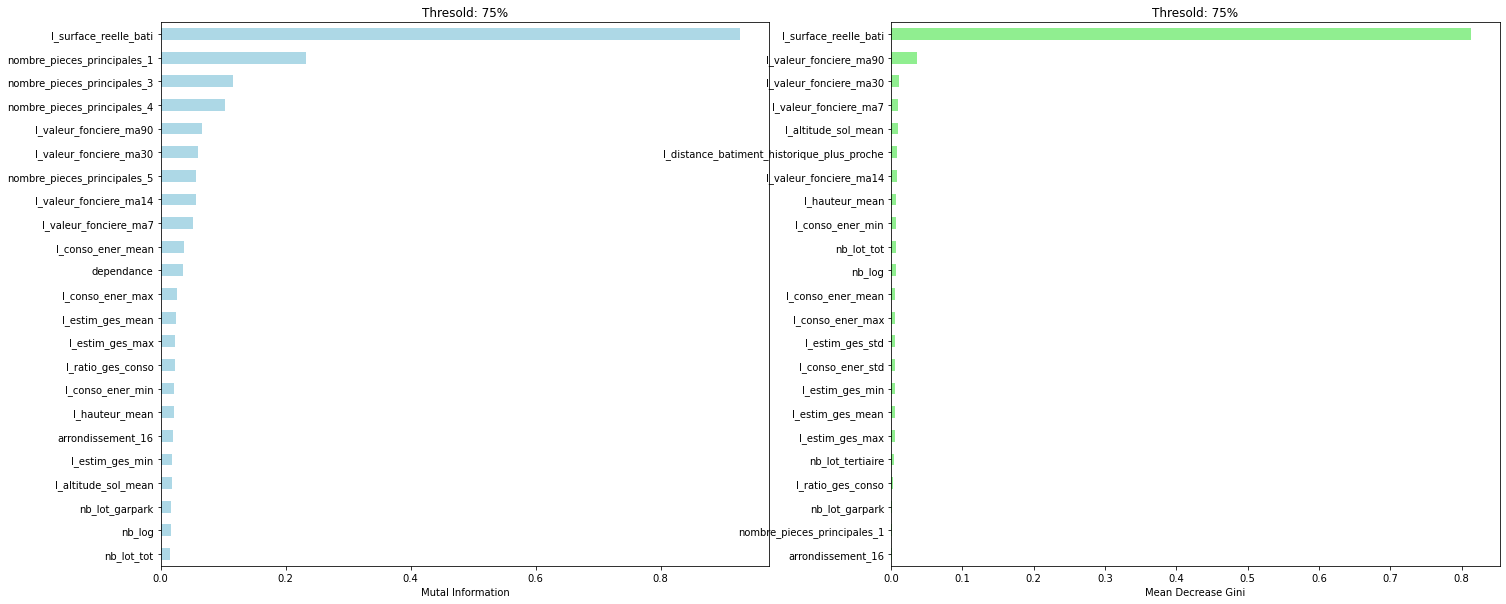

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))

mi_values[important_features_mi]\
    .sort_values()\
    .plot.barh(ax=axes[0], color="lightblue")

axes[0].set_xlabel("Mutal Information")
axes[0].set_title(f"Thresold: {mi_threshold}")

mdg_values[important_features_mdg]\
    .sort_values()\
    .plot.barh(ax=axes[1], color="lightgreen")

axes[1].set_xlabel("Mean Decrease Gini")
axes[1].set_title(f"Thresold: {mdg_threshold}"); 

In [56]:
# get the union of the two sets of important features
selected_features = list(set(important_features_mi + important_features_mdg))

rich.print(f"{len(selected_features)} features sélectionnées")
rich.print(selected_features) 

27 features sélectionnées

[
    'l_valeur_fonciere_ma14',
    'nb_log',
    'l_hauteur_mean',
    'l_estim_ges_min',
    'arrondissement_16',
    'l_altitude_sol_mean',
    'nb_lot_garpark',
    'l_surface_reelle_bati',
    'l_distance_batiment_historique_plus_proche',
    'l_ratio_ges_conso',
    'nb_lot_tot',
    'nombre_pieces_principales_3',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma90',
    'l_valeur_fonciere_ma30',
    'nombre_pieces_principales_4',
    'dependance',
    'l_estim_ges_mean',
    'l_conso_ener_min',
    'l_conso_ener_std',
    'nombre_pieces_principales_5',
    'l_estim_ges_max',
    'l_conso_ener_max',
    'l_estim_ges_std',
    'nb_lot_tertiaire',
    'l_conso_ener_mean',
    'nombre_pieces_principales_1'
]

In [57]:
X_tr_reduced = get_feature_vector(df_train, features=selected_features, return_df=False)
X_val_reduced = get_feature_vector(df_val, features=selected_features, return_df=False)
X_te_reduced = get_feature_vector(df_test, features=selected_features, return_df=False)

y_tr = get_target_vector(df_train, "l_valeur_fonciere", return_series=False) 
y_val = get_target_vector(df_val, "l_valeur_fonciere", return_series=False)
y_te = get_target_vector(df_test, "l_valeur_fonciere", return_series=False)

In [58]:
X_tr_reduced.shape

(95241, 27)

In [213]:
# indicate if we want to use the reduced feature matrix based on feature selection

use_selected_features = True 

if use_selected_features: 
    X_tr_, X_val_, X_te_ = X_tr_reduced, X_val_reduced, X_te_reduced
else:
    X_tr_, X_val_, X_te_ = X_tr, X_val, X_te

input_size = X_tr_.shape[1]

## Entrainement/Validation

### Création des `DataLoader`

In [214]:
# scale feature matrix before passing through the network

scaler = MinMaxScaler()

X_tr_scaled, scaler = scale_features(scaler, X_tr_, fit=True)
X_val_scaled = scale_features(scaler, X_val_)
X_te_scaled = scale_features(scaler, X_te_)

In [225]:
use_scaled_features = True

if use_scaled_features:
    features_tr, features_val, features_te = X_tr_scaled, X_val_scaled, X_te_scaled
else:
    features_tr, features_val, features_te = X_tr_, X_val_, X_te_

trainloader = to_dataloader(features_tr, y_tr)
valloader = to_dataloader(features_val, y_val)
testloader = to_dataloader(features_te, y_te)

### Instantiation

In [226]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [241]:
hidden_sizes = [
    150, 
    100, 
    50
]

mlp_args = {
    "input_size": input_size,
    "hidden_sizes": hidden_sizes, 
    "output_size": 1,
    "activation_funcs": [nn.Tanh(), nn.Tanh(), nn.ReLU()], 
    "dropout_probs": [0.2, 0.2, 0.]
}

mlp = MLP(**mlp_args).to(device) 
mlp

MLP(
  (input_layer): Linear(in_features=27, out_features=150, bias=True)
  (output_layer): Linear(in_features=50, out_features=1, bias=True)
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Dropout(p=0.2, inplace=False)
  )
  (hidden_layers): ModuleList(
    (0): Linear(in_features=150, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
)

### Optimisation

In [242]:
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [243]:
train_losses, validation_losses = optimize_mlp(
    mlp, 
    trainloader, 
    valloader, 
    optimizer,
    criterion, 
    n_epochs=100, 
    device=device,
    lr_scheduler=scheduler)

Epoch: 66/100 	Training Loss: 0.079114 	Validation Loss: 0.066778	Learning Rate: 0.005151:  66%|██████▌   | 66/100 [29:09<15:01, 26.51s/it]


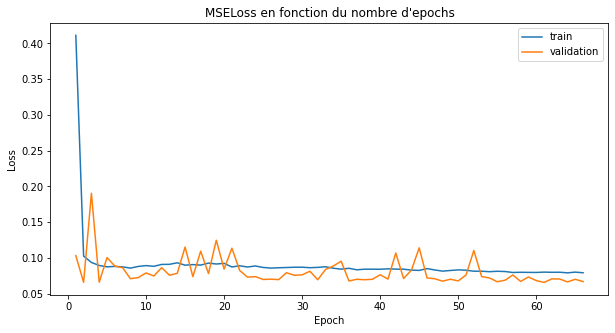

In [247]:
tmp = pd.DataFrame({
    "epoch": range(1, len(train_losses) + 1),
    "train_loss": train_losses,
    "validation_loss": validation_losses
})

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=tmp, x="epoch", y="train_loss", ax=ax, label="train")
sns.lineplot(data=tmp, x="epoch", y="validation_loss", ax=ax, label="validation")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("MSELoss en fonction du nombre d'epochs")

del tmp;

### Prédiction

In [248]:
mlp_results = {"true": [], "pred": []}

for X, y in testloader:
    y = np.exp(y.cpu().numpy())
    mlp_results["true"].append(y)
    mlp_results["pred"].append(predict_mlp(mlp, X, device))

mlp_results["pred"] = np.concatenate(mlp_results["pred"])
mlp_results["true"] = np.concatenate(mlp_results["true"])

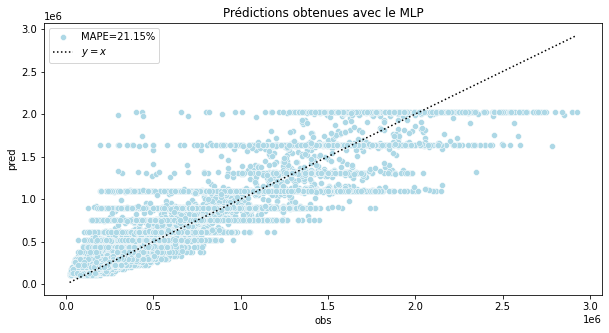

In [249]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_predictions(
    y_true=mlp_results["true"],
    y_pred=mlp_results["pred"],
    title="Prédictions obtenues avec le MLP",
    ax=ax
); 